In [218]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
import sys
from pathlib import Path

sys.path.insert(0, "../scripts")


from utils import train_test_split, image_batch_generator, get_train_augmentation, apply_augmentation
from utils import DATASET_PATH, DS_IMAGES, DS_MASKS
import utils
from vis import imshow, anshow
import vis
import models
import metrics

IMAGE_NAMES = os.listdir(DS_IMAGES)

import importlib
importlib.reload(utils)
importlib.reload(vis)
importlib.reload(models)
importlib.reload(metrics)

<module 'metrics' from '/home/tigran-analysed/Desktop/analysed.ai/table_extractor/notebooks/../scripts/metrics.py'>

In [14]:
model = models.load_unet_model((512, 512), 2)

In [16]:
checkpoint = tf.train.Checkpoint(step=tf.Variable(1), optimizer=tf.keras.optimizers.Adam(), net=model)
# print(f"loading checkpoint {'training_checkpoints/' + '2022.07.30-22/' + 'ckpt-238'}")
status = checkpoint.restore("../checkpoints/ckpt-238")
status

In [56]:
images, masks = utils.read_inf_sample(IMAGE_NAMES, (512, 512))

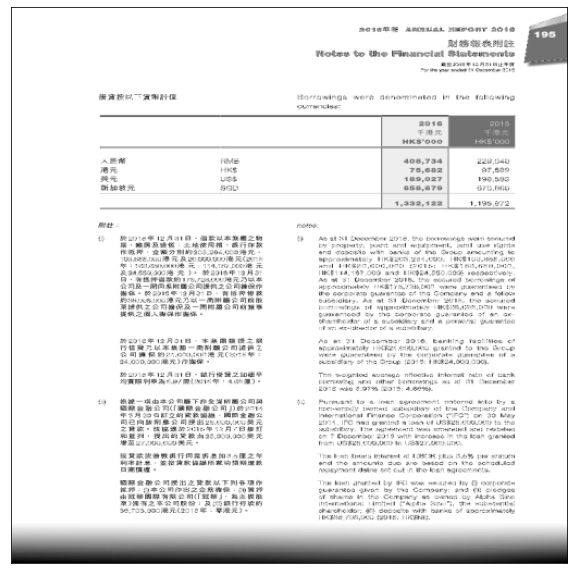

In [57]:
vis.imshow(images[0][:, :, 0])

In [166]:
%time

pred_mask = model(images, training=False)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.82 µs


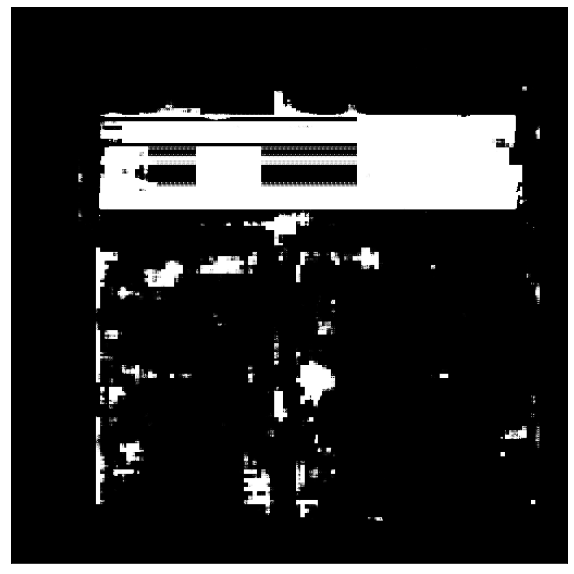

In [167]:
vis.imshow(pred_mask[0])

In [168]:
pred_mask.shape

TensorShape([1, 512, 512, 1])

In [169]:
pred_mask = (np.squeeze(pred_mask) * 255).astype(np.uint8)

In [159]:
# thresh = thresh = cv2.threshold(np.array(masks[0] * 255, dtype=np.uint8), 100, 255, cv2.THRESH_BINARY)[1]
# thresh = thresh = cv2.threshold(pred_mask, 200, 255, cv2.THRESH_BINARY)[1]
# contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)

In [170]:
# vis.imshow(thresh)

In [178]:
final_mask = np.zeros_like(pred_mask)

In [209]:
list(Path("../datasets/images/").glob("cTDaR_t10040*"))

[PosixPath('../datasets/images/cTDaR_t10040.jpg')]

In [192]:
os.path.exists("../datasets/images/cTDaR_t10040_valid.png")

True

In [220]:
images, masks = utils.read_inf_sample(IMAGE_NAMES, (512, 512))

In [222]:
for img, mask in zip(images, masks):
    pred_mask = model(images, training=False)
    pred_mask = (np.squeeze(pred_mask) * 255).astype(np.uint8)

    thresh = thresh = cv2.threshold(pred_mask, 200, 255, cv2.THRESH_BINARY)[1]
    contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)

    final_mask = np.zeros_like(pred_mask)

    for i, c in enumerate(contours):
        if len(c) > 200:
            min_x, max_x = np.squeeze(c)[:, 0].min(), np.squeeze(c)[:, 0].max()
            min_y, max_y = np.squeeze(c)[:, 1].min(), np.squeeze(c)[:, 1].max()
            final_mask[min_y:max_y, min_x:max_x] = 255

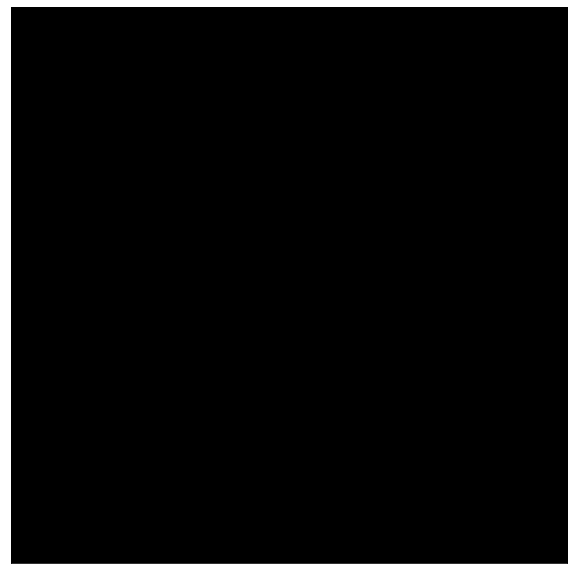

In [223]:
vis.imshow(final_mask)